In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import simulator as faas


seed = 1

## Set up priors


In [15]:
import delfi.distribution as dd

upper = np.array([12,  10, 12,  10, -4, -4, -6,-4] + [0.1,0])
lower = np.array([4,  2, 4, 2, -10, -10, -10, -12] + [-0.1,-0.5])


upper = np.array([12,  10, 12,  10, 0])# -6,-4] + [0.1,0])
lower = np.array([4,  2, 4, 2, -10])# -10, -12] + [-0.1,-0.5])

prior_mean = np.array([0]*8 + [1.1e-03, -3.9e-01])
prior_cov = np.diag(np.array([10]*8+[(0.0011*0.2)**2, (0.39*0.2)**2]))

prior = dd.Uniform(lower= lower, upper=upper, seed=seed)


epsilon_mean = np.array([0]*94)
epsilon_cov = np.diag(np.array([0.5] * 94))
epsilon_prior = dd.Gaussian(m=epsilon_mean, S=epsilon_cov, seed=seed)

## Set up Simulator

In [3]:
faasSimulator = faas.faas_Model()

## repeating last fratio for short rows
def simulator(th, seed, simulator_args, batch):
    
    eps_prior = simulator_args[0]
    eps = eps_prior.gen()
    #eps.index = ['epsilon' + str(i) for i in np.arange(0,94)]
    eps = [0] * 94
    
    
    return faasSimulator.forward(np.concatenate([np.concatenate([th, [-4.509306e+00, -6.162727e+00,
  -6.585027e+00,  1.100000e-03, -3.900000e-01]]), eps]), seed)

simulator_args = [epsilon_prior]
theta0 = faasSimulator.theta0

theta_f = [8.886491e+00,  7.924279e+00,
   1.050515e+01,  7.397940e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00,
  -6.585027e+00,  1.100000e-03, -3.900000e-01]




In [5]:
from delfi.simulator.BaseSimulator import BaseSimulator

class Faas(BaseSimulator):
    def __init__(self, batch=0, simulator_args = simulator_args, seed=None):
        """Faas simulator

        Parameters
        ----------
        seed : int or None
            If set, randomness across runs is disabled
        """
        dim_param = 10

        super().__init__(dim_param=dim_param, seed=seed)
        self.batch = batch
        self.simulator_args = simulator_args
        self.seed = seed
        self.FaasSimulator = simulator
        self.time = np.genfromtxt('data/time_points.csv', delimiter=',')

    def gen_single(self, params):
        """Forward model for simulator for single parameter set

        Parametersnp.nanstd(stats, axis=0)
        ----------
        params : list or np.array, 1d of length dim_param
            Parameter vector

        Returns
        -------
        dict : dictionary with data
            The dictionary must contain a key data that contains the results of
            the forward run. Additional entries can be present.
        """
        params = np.asarray(params)

        assert params.ndim == 1, 'params.ndim must be 1'

        hh_seed = self.seed

        states = self.FaasSimulator(th = params, seed = seed, simulator_args = self.simulator_args, batch = self.batch)
        if np.isnan(states.flatten()).any() or np.isinf(states.flatten()).any():
            states = np.random.randn(94,259)
                #return d.flatten()
        
        return {'data': states, 'time': self.time}

## Summary Statistics

This is working well for 2-4 params, try with more

Very close with 5

-- If this doesn't work look into finding peak/peak width using the numpy signals package, and consider calculated the energy

use only good summaries

In [6]:
from delfi.summarystats.BaseSummaryStats import BaseSummaryStats
from scipy import stats as spstats
from scipy.signal import find_peaks, peak_widths

class FaasStats(BaseSummaryStats):
    """Moment based SummaryStats class for the faas model

    Calculates summary statistics
    """
    def __init__(self, seed=None):
        """See SummaryStats.py for docstring"""
        super(FaasStats, self).__init__(seed=seed)
        self.time = np.genfromtxt('data/time_points.csv', delimiter=',')
    
    def compressor(self, d, t):
            comp_d = []

            for i in d:
                #mean of final ten entries
                final = np.mean(i[-10:])
                #median of 3 highest points
                peak = np.max(i)
                #time to peak
                time_peak = t[np.argmax(i)]
                #sd = np.std(i[-10:])
                #time to final
                #time_final = np.argmax(np.logical_and((i[time_peak:] >= final - sd),(i[time_peak:] <= final + sd)) == True) + time_peak
                diff_peak_final = (final - peak)/peak * 100
                first = np.mean(i[:5])
                diff_peak_first = first - peak
                diff_first_final = first - final
                mid = i[len(i)//2]
                diff_first_mid = first - mid
                diff_final_mid = final - mid
                diff_peak_mid = peak - mid
                if time_peak > 259:
                    time_peak = np.random.uniform(0, 259)
                if diff_peak_final > 25:
                    diff_peak_final = np.random.uniform(0.1, 0.2)
                
                min_slope = np.diff(i).min()
                max_slope = np.diff(i[10:]).max()
                
                max_slope_index = t[np.argmax(np.diff(i[10:])) + 10] 
                min_slope_index = t[np.argmin(np.diff(i[10:]))] 
                
                #mean slope for first 10, 20, and then the remaining trace
                mean_10 = np.mean(np.diff(i)[:10])
                mean_30 = np.mean(np.diff(i)[10:30])
                mean_rest = np.mean(np.diff(i)[30:])
                
                #moments
                #mom_1 = stats.moment(i, 1, nan_policy = 'omit')
                mom_2 = stats.moment(i, 2, nan_policy = 'omit')
                mom_3 = stats.moment(i, 3, nan_policy = 'omit')
                mom_4 = stats.moment(i, 4, nan_policy = 'omit')
                mom_5 = stats.moment(i, 5, nan_policy = 'omit')
                
                #moments of differenced trace
                mom_diff_1 = stats.moment(np.diff(i), 1, nan_policy = 'omit')
                mom_diff_2 = stats.moment(np.diff(i), 2, nan_policy = 'omit')
                mom_diff_3 = stats.moment(np.diff(i), 3, nan_policy = 'omit')
                mom_diff_4 = stats.moment(np.diff(i), 4, nan_policy = 'omit')
                mom_diff_5 = stats.moment(np.diff(i), 5, nan_policy = 'omit')
                
                # peaks
                peaks = find_peaks(i)
                peaks_widths = peak_widths(i, peaks)
                
                comp_d.append([time_peak, min_slope, max_slope, diff_peak_final, diff_peak_first, max_slope_index, 
                               min_slope_index, mean_10, mean_30, mean_rest, diff_first_mid, diff_final_mid, 
                               diff_peak_mid, mom_2, mom_3, mom_4, mom_5,
                               mom_diff_1, mom_diff_2, mom_diff_3, mom_diff_4, mom_diff_5,
                               peaks, peaks_widths])


            out = np.asarray(comp_d).flatten()
            #out = comp_d
            if np.isnan(out).any() or np.isinf(out).any():
                return np.random.randn(out.shape[0])**2
                #return d.flatten()

            #return out + np.random.rand(6*len(d))
            return out
    
    def calc(self, repetition_list):
        """Calculate summary statistics

        Parameters
        ----------
        repetition_list : list of dictionaries, one per repetition
            data list, returned by `gen` method of Simulator instance

        Returns
        -------
        np.array, 2d with n_reps x n_summary
        """
        stats = []
        for r in range(len(repetition_list)):
            x = repetition_list[r]

            N = x['data']
            t = self.time

            # concatenation of summary statistics
            sum_stats_vec = self.compressor(N, t)
            #sum_stats_vec = sum_stats_vec[0:self.n_summary]

            stats.append(sum_stats_vec)

        return np.asarray(stats)
    


## Generator

In [16]:
import delfi.generator as dg


m = Faas(seed=0)
s = FaasStats(seed = 0)
g = dg.Default(model=m, prior=prior, summary=s)

## Test with simulated data

In [17]:
# true parameters and respective labels
true_params = np.array([8.886491e+00,  7.924279e+00,
   1.050515e+01,  7.397940e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00,
  -6.585027e+00,  1.100000e-03, -3.900000e-01])       
labels_params = ['logKonTN', 'logKonTC', 'logKonRN', 'logKonRC', 'logKDTN', 'logKDTC', 'logKDRN', 'logKDRC', 'malpha', 'alpha0']



true_params = np.array([8.886491e+00,  7.924279e+00,
   1.050515e+01,  7.397940e+00, -3.682371e+00])       
labels_params = ['logKonTN', 'logKonTC', 'logKonRN', 'logKonRC', 'logKDTN']# 'logKDRN', 'logKDRC', 'malpha', 'alpha0']


# observed data: simulation given true parameters
obs = m.gen_single(true_params)
print(obs['data'].shape)
print(obs['data'].flatten().shape)

(94, 259)
(24346,)


In [ ]:
plt.plot(np.diff(obs['data'][6]))

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

fig = plt.figure(figsize=(7,5))
ax = plt.subplot()
plt.plot(obs['data'])
plt.ylabel('voltage (mV)')
plt.title('observed data')
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])


In [18]:
obs_stats = s.calc([obs])
print(obs_stats)
print(obs_stats.shape)

[[ 2.20000000e-01 -3.49515961e-02  1.70920147e-04 ...  5.81832456e-05
   5.77580321e-06  5.83501679e-07]]
(1, 2162)


## Inference

In [19]:
seed_inf = 1

pilot_samples = 500

# training schedule
n_train = 500
n_rounds = 5

# fitting setup
minibatch = 100
epochs = 100
val_frac = 0.05

# network setup
n_hiddens = [50]*10

# convenience
prior_norm = True

# MAF parameters
density = 'maf'
n_mades = 10       # number of MADES

In [23]:
import delfi.inference as infer
 
# inference object
res = infer.SNPEC(g,
                obs=obs_stats,
                n_hiddens=n_hiddens,
                seed=seed_inf,
                pilot_samples=pilot_samples,
                n_mades=n_mades,
                prior_norm=prior_norm,
                density=density, verbose=True)

# train
log, _, posterior = res.run(
                    n_train=n_train,
                    n_rounds=n_rounds,
                    minibatch=minibatch,
                    epochs=epochs,
                    silent_fail=False,
                    proposal='prior',
                    val_frac=val_frac,
                    verbose=True,)


[ 2.58412800e+00 -3.59091089e-02  4.22762629e-03 ...  1.73108921e-05
  1.55636776e-06  1.39876442e-07]
[8.49728928e+00 2.30894441e-03 1.90206491e-05 ... 5.34230559e-10
 8.76988738e-12 1.56008187e-13]
(2162,)
(2162,)


Stopping at epoch 80.0, training loss = 2.328717252556493, validation loss = 1.7367440222418755




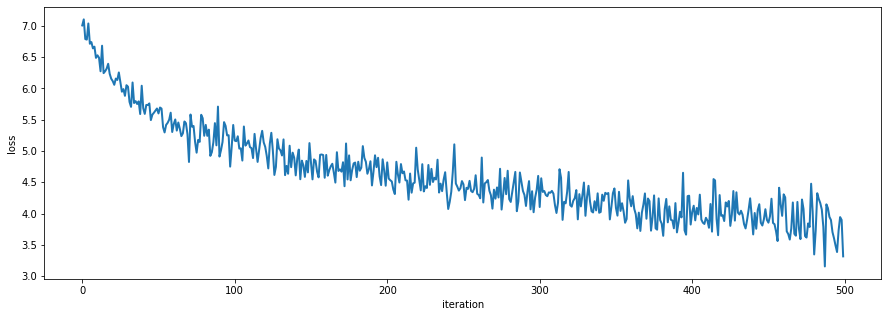

In [24]:
fig = plt.figure(figsize=(15,5))

plt.plot(log[0]['loss'],lw=2)
plt.xlabel('iteration')
plt.ylabel('loss');

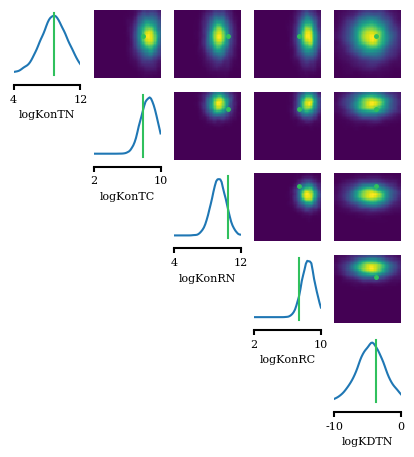

In [25]:
from delfi.utils.viz import samples_nd

#lower= [4,2,4,2], upper=[12,10,12,10]

prior_min = lower
prior_max = upper
prior_lims = np.concatenate((prior_min.reshape(-1,1),prior_max.reshape(-1,1)),axis=1)

posterior_samples = posterior[0].gen(10000)

###################
# colors
hex2rgb = lambda h: tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

# RGB colors in [0, 255]
col = {}
col['GT']      = hex2rgb('30C05D')
col['SNPE']    = hex2rgb('2E7FE8')
col['SAMPLE1'] = hex2rgb('8D62BC')
col['SAMPLE2'] = hex2rgb('AF99EF')

# convert to RGB colors in [0, 1]
for k, v in col.items():
    col[k] = tuple([i/255 for i in v])

###################
# posterior
fig, axes = samples_nd(posterior_samples,
                       limits=prior_lims,
                       ticks=prior_lims,
                       labels=labels_params,
                       fig_size=(5,5),
                       diag='kde',
                       upper='kde',
                       hist_diag={'bins': 50},
                       hist_offdiag={'bins': 50},
                       kde_diag={'bins': 50, 'color': col['SNPE']},
                       kde_offdiag={'bins': 50},
                       points=[true_params],
                       points_offdiag={'markersize': 5},
                       points_colors=[col['GT']],
                       title='');

In [ ]:
print(np.median(posterior_samples))

In [ ]:
fig = plt.figure(figsize=(7,5))

y_obs = obs['data']
t = obs['time']
duration = np.max(t)

num_samp = 2

# sample from posterior
x_samp = posterior[0].gen(n_samples=num_samp)

# reject samples for which prior is zero
ind = (x_samp > prior_min) & (x_samp < prior_max)
params = x_samp[np.prod(ind,axis=1)==1]

num_samp = len(params[:,0])

# simulate and plot samples
V = np.zeros((len(t),num_samp))
for i in range(num_samp):
    x = m.gen_single(params[i,:])
    V[:,i] = x['data']
    plt.plot(t, V[:, i], color = col['SAMPLE'+str(i+1)], lw=2, label='sample '+str(num_samp-i))

# plot observation
plt.plot(t, y_obs, '--',lw=2, label='observation')
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc='upper right')

ax.set_xticks([0, duration/2, duration])
ax.set_yticks([-80, -20, 40]);